In [1]:
from allennlp.predictors.predictor import Predictor
import allennlp_models.tagging
from collections import defaultdict, OrderedDict
import networkx as nx
import json
import numpy as np
import random
import pickle as pkl
import csv
import os
from nltk.tokenize import sent_tokenize 
import matplotlib.pyplot as plt
import spacy
# from tqdm import tqdm
import tqdm
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

nlp.add_pipe(nlp.create_pipe('sentencizer')) # updated

In [2]:
predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/structured-prediction-srl-bert.2020.12.15.tar.gz")

In [3]:
def extract_kg_triples(verb_dict, words):
    '''Take verb dict from SRL module and extract head, verb, tails arrangement
    '''
    head = []
    tails = {}
    verb = verb_dict['verb']
    tags = verb_dict['tags']
    
    for i in range(len(words)):
        if tags[i] == 'B-ARG0' or tags[i] == 'I-ARG0':
            head.append(words[i])
        elif tags[i] == 'B-ARG1' or tags[i] == 'I-ARG1':
            head.append(words[i])
        elif 'B-ARG' in tags[i] or 'I-ARG' in tags[i]:
            index = tags[i].split('ARG')[-1]
            try:
                index = int(index)
            except:
                continue
            try:
                tails[index].append(words[i])
            except:
                tails[index] = [words[i]]
    return (head, verb, tails)

def remove_stop_words(text):
    sent = []
    for word in text.split(' '):
            lexeme = nlp.vocab[word]
            if lexeme.is_stop == False:
                sent.append(word)
    return ' '.join(sent)
    
        
def find_noun_chunks(words):
    doc = nlp(words)

    if not list(doc.noun_chunks):
        return [words]
    chunks = []
    for chunk in doc.noun_chunks:
        sent = remove_stop_words(chunk.text)
#         sent = chunk.text
        chunks.append(sent)
    return chunks

def add_im(h, t, DG, weight):
    
    DG.add_node(h, bipartite=0)
    DG.add_node(t, bipartite=1)
    DG.add_edge(h, t, weight=weight)
    
    
def create_edge_weight_dict(ht_dict, sent):
    srl = predictor.predict(
                sentence = sent
            )
    
    

    verbs = srl['verbs']
    words = srl['words']

    # TODO
    # remove predicates and just attach arg0/arg1 to associated args.  
    # Quantify strength of edges and setting a threshold, i.e. based on number of times association appears in text.
    # This can be used as weight.
    # 29th July deadline
    
    

    # find pairs and calculate weights
    for verb_dict in verbs:
                    head, verb, tails = extract_kg_triples(verb_dict, words)
                    head = ' '.join(head)
                    heads = find_noun_chunks(head)
                    for h in heads:
                        if h == '':
                            continue
                        
                        for key in tails.keys():
                            tail = ' '.join(tails[key])
                            tail = find_noun_chunks(tail)
                            for t in tail:
                                if t == '':
                                    continue
                                ht_dict[(h,t)]+=1
                                
    
def create_kg_from_dict(ht_dict, DG, threshold = 1, is_remove_stop_words = True):
    ent_labels = ['PERSON', 'ORG', 'GPE', 'LOC']

    # TODO
    # remove predicates and just attach arg0/arg1 to associated args.  
    # Quantify strength of edges and setting a threshold, i.e. based on number of times association appears in text.
    # This can be used as weight.
    # 29th July deadline
    
    # add pairs and weights to graph
    for (h,t) in ht_dict:
        weight = ht_dict[(h,t)]
        h = ''.join(ch for ch in h if ch.isalnum() or ch is ' ')
        t = ''.join(ch for ch in t if ch.isalnum() or ch is ' ')
        if weight >= threshold and '  ' not in h and '  ' not in t:
            
            if is_remove_stop_words:
                h = remove_stop_words(h)
                t = remove_stop_words(t)
            
            
            in_ent_labels = False
            
            h_doc = nlp(h)
            for ent in h_doc.ents:
                if ent.label_ in ent_labels:
                    in_ent_labels = True
                    break
                    
            if in_ent_labels:
                continue
                    
            t_doc = nlp(t)
            for ent in t_doc.ents:
                if ent.label_ in ent_labels:
                    in_ent_labels = True
                    break
                    
            if in_ent_labels:
                continue
            
            add_im(h,t, DG, weight)
    
    

def display_kg(DG):
    pos = nx.spring_layout(DG, k=3*1/np.sqrt(len(DG.nodes())), iterations=20)
    plt.figure(figsize=(20,20))
    nx.draw(DG, pos, edge_color='black', width=1, linewidths=1,
                node_size=500, arrowsize=0.001, node_color='seagreen', alpha=0.9,
                labels={node: node for node in DG.nodes()}, font_size=20)
    plt.axis('off')

def save_admatrix_nodelist(DG, src_dir):
    if not os.path.isdir(src_dir):
        os.mkdir(src_dir)
    admatix = nx.adjacency_matrix(DG).todense()
    np.savetxt(os.path.join(src_dir, "KGAM_SRL.csv"), np.array(admatix, dtype=np.int), delimiter=",")

    
    with open(os.path.join(src_dir, 'KGNL_SRL.csv'), 'w', newline='') as myfile:
         wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
         wr.writerow(list(DG.nodes))
    

In [10]:
val_set_artist_titles = {
    'e624f5dfe2.jpg': {
        'artist': ['Pieter Claesz', 'P. Claesz', 'P Claesz'],
        'titles': ['still life with crystal ball', 'vanité avec la boule de cristal']
    },
    'db5761a2a1.jpg': {
        'artist': ['Pieter Claesz', 'P. Claesz', 'P Claesz'],
        'titles': ['Vanitas still life', 'Vanitas with Violin and Glass Ball']
    },  # duplicate of 'fed306f057.jpg'
    'fed306f057.jpg': {
        'artist': ['Pieter Claesz', 'P. Claesz', 'P Claesz'],
        'titles': ['Vanitas with Violin and Glass Ball']
    },
    'fd87965987.jpg': {
        'artist': ['Pieter Claesz', 'P. Claesz', 'P Claesz'],
        'titles': ['A Varitas (Still Life)']
    },
    '8ad536eb55.jpg': {
        'artist': ['Pieter Claesz', 'P. Claesz', 'P Claesz'],
        'titles': ['Vanitas 1630', 'Vanitas Still Life']
    },
    'a964dd4aef.jpg': {
        'artist': ['Harmen Steenwyck', 'Harmen van Steenwyck', 'H. Steenwyck', 'H. van Steenwyck',
                  'H Steenwyck', 'H van Steenwyck'],
        'titles': ['Still Life : An Allegory of the Vanities of Human Life']
    },
    '2424027234.jpg': {
        'artist': ['Harmen Steenwyck', 'Harmen van Steenwyck', 'H. Steenwyck', 'H. van Steenwyck'],
        'titles': ['Still Life of Game, Fish, Fruit and Kitchen Utensils']
    },
    '86e7643246.jpg': {
        'artist':  ['Harmen Steenwyck', 'Harmen van Steenwyck', 'H. Steenwyck', 'H. van Steenwyck',
                  'H Steenwyck', 'H van Steenwyck'],
        'titles': ['Vanitas stilleven']
    },
    '05d9284b10.jpg': {
        'artist': ['Harmen Steenwyck', 'Harmen van Steenwyck', 'H. Steenwyck', 'H. van Steenwyck',
                  'H Steenwyck', 'H van Steenwyck'],
        'titles': ['Vanitas stilleven met schedel, boeken en fruit']
    },
    '8ad536eb55.jpg': {
        'artist': ['Harmen Steenwyck', 'Harmen van Steenwyck', 'H. Steenwyck', 'H. van Steenwyck',
                  'H Steenwyck', 'H van Steenwyck'],
        'titles': ['White skull and book painting']
    },
    '2424133048.jpg': {
        'artist': ['Jacques de Gheyn II', 'de Gheyn II', 'J. de Gheyn II', 'J de Gheyn II'],
        'titles': ['Vanitas Still Life']
    },
    '8d4205809e.jpg': {
        'artist': ['Edwaert Collier', 'E. Collier', 'E Collier'],
        'titles': ['Vanitas Still Life with Books and Manuscripts and a Skull']
    },
    '5aadcb7882.jpg': {
        'artist': ['Edwaert Collier', 'E. Collier', 'E Collier'],
        'titles': ['Vanitas Still Life']
    },
    'db39fb81b1.jpg': {
        'artist': ['Guercino'],
        'titles': ['a Vanitas Still life with a skull atop a book, an hourglass and two glass vases of flowers', 
                   'Vanitas Still life with a skull atop a book, an hourglass and two glass vases of flowers']
    },
    'd906904f4f.jpg': {
        'artist': ['Dutch School'],
        'titles': ['A vanitas still life with a skull, a violin, a music book, various other books and instruments on a draped table, before a red curtain']
    },
    'd6c400594b.jpg': {
        'artist': ['David Bailly', 'D. Bailly', 'D Bailly'],
        'titles': ['Vanitas']
    },
    'c61e32741c.jpg': {
        'artist': ['Hendrik Andriessen', 'H. Andriessen', 'H Andriessen'],
        'titles': ['Vanitas Still-Life']
    },
    'aa93e919ac.jpg': {
        'artist': ['Sebastian Stoskopff', 'S. Stoskopff', 'S Stoskopff'],
        'titles': ['Vanitas Still-Life with Skull']
    },
    'a861ea64fb.jpg': {
        'artist': ['Willem Claesz Heda', 'Willem Claesz', 'W. Claesz', 'W. Claesz Heda', 
                   'W Claesz', 'W Claesz Heda'],
        'titles': ['Still Life']
    },
    '8862bd2fb0.jpg': {
        'artist': ['Philippe de Champaigne', 'de Champaigne', 'P. de Champaigne', 'P de Champaigne'],
        'titles': ['Vanitas Still Life']
    }
}

In [11]:
len(web_texts)

96

In [12]:
with open('data/vanitas_meaning_text.json') as f:
    web_texts = json.load(f)

In [20]:
train_texts = []
val_texts = {}

counter = 0 

for text in web_texts:
    counter +=1
    is_val = False
    for key in val_set_artist_titles.keys():
        if key not in val_texts:
            val_texts[key] = []
        painting = val_set_artist_titles[key]
        artist = painting['artist']
        titles = painting['titles']
        for name in artist:
            for title in titles:
                if name.lower() in text.lower() and title.lower() in text.lower():
                    is_val = True
                    val_texts[key].append(text)
                    break
                if is_val:
                    break
            if is_val:
                break
        if is_val:
            break
    if not is_val:
        train_texts.append(text)
    

In [14]:
len(train_texts)

69

In [21]:
counter_val = 0

for key in val_texts.keys():
    for _ in val_texts[key]:
        counter_val +=1
print(counter_val)

27


In [19]:
counter

96

In [32]:
'oris van Son: Allegory on Human Life  1658 – 1660      * 4.9 Edwaert Collier: Vanitas – Still Life with Books and Manuscripts and a Skull  1663      * 4.10 Pieter Boel: Allegory of the Vanities of the World  1663    * 5 The Legacy of Vanitas Ar'

'oris van Son: Allegory on Human Life  1658 – 1660      * 4.9 Edwaert Collier: Vanitas – Still Life with Books and Manuscripts and a Skull  1663      * 4.10 Pieter Boel: Allegory of the Vanities of the World  1663    * 5 The Legacy of Vanitas Ar'

In [51]:
val_texts.keys()

dict_keys(['e624f5dfe2.jpg', 'db5761a2a1.jpg', 'fed306f057.jpg', 'fd87965987.jpg', '8ad536eb55.jpg', 'a964dd4aef.jpg', '2424027234.jpg', '86e7643246.jpg', '05d9284b10.jpg', '2424133048.jpg', '8d4205809e.jpg', '5aadcb7882.jpg', 'db39fb81b1.jpg', 'd906904f4f.jpg', 'd6c400594b.jpg', 'c61e32741c.jpg', 'aa93e919ac.jpg', 'a861ea64fb.jpg', '8862bd2fb0.jpg'])

In [13]:
val_texts['e624f5dfe2.jpg']

[]

In [33]:
for key in val_texts.keys():
    if val_texts[key]:
        print('full', key, val_set_artist_titles[key])
        
    else:
        print('empty')

empty
full db5761a2a1.jpg {'artist': ['Pieter Claesz', 'P. Claesz', 'P Claesz'], 'titles': ['Vanitas still life', 'Vanitas with Violin and Glass Ball']}
empty
empty
empty
empty
full 2424027234.jpg {'artist': ['Harmen Steenwyck', 'Harmen van Steenwyck', 'H. Steenwyck', 'H. van Steenwyck'], 'titles': ['Still Life of Game, Fish, Fruit and Kitchen Utensils']}
empty
empty
full 2424133048.jpg {'artist': ['Jacques de Gheyn II', 'de Gheyn II', 'J. de Gheyn II', 'J de Gheyn II'], 'titles': ['Vanitas Still Life']}
empty
full 5aadcb7882.jpg {'artist': ['Edwaert Collier', 'E. Collier', 'E Collier'], 'titles': ['Vanitas Still Life']}
empty
empty
full d6c400594b.jpg {'artist': ['David Bailly', 'D. Bailly', 'D Bailly'], 'titles': ['Vanitas']}
empty
empty
full a861ea64fb.jpg {'artist': ['Willem Claesz Heda', 'Willem Claesz', 'W. Claesz', 'W. Claesz Heda', 'W Claesz', 'W Claesz Heda'], 'titles': ['Still Life']}
full 8862bd2fb0.jpg {'artist': ['Philippe de Champaigne', 'de Champaigne', 'P. de Champaigne

In [36]:
val_texts['d6c400594b.jpg']

["  ![Encyclopedia Britannica logo] https://cdn.britannica.com/mendel/eb- logo/b-50-pb5.png   ____ Browse ____ Search  Quizzes Games On This Day  Subscribe  Now Login ____    * Entertainment & Pop Culture   * Geography & Travel   * Health & Medicine   * Lifestyles & Social Issues   * Literature   * Philosophy & Religion   * Politics, Law & Government   * Science   * Sports & Recreation   * Technology   * Visual Arts   * World History    * Quizzes   * Games   * Podcasts   * On This Day   * Biographies   * Week In Review   * Topic Summaries   * Infographics   * Demystified   * Lists   * #WTFact   * Companions   * Image Galleries   * Spotlight   * The Forum    * Entertainment & Pop Culture   * Geography & Travel   * Health & Medicine   * Lifestyles & Social Issues   * Literature   * Philosophy & Religion   * Politics, Law & Government   * Science   * Sports & Recreation   * Technology   * Visual Arts   * World History    * Britannica Classics   Check out these retro videos from Encycloped

In [46]:
# with open('data/vanitas_meaning_text_val.json', 'w') as f:
#     json.dump(val_texts, f)

In [47]:
# train_val_split = 0.8

# split_point = int(len(web_texts)*train_val_split)

# train_texts = web_texts[:split_point]
# val_texts = web_texts[split_point:]




# with open('data/vanitas_meaning_val_texts.txt', 'w') as f:
#     json.dump(val_texts, f)

ht_dict = defaultdict(int)
for i in tqdm.notebook.trange(len(train_texts), position = 0, desc='texts'):
        sents = sent_tokenize(train_texts[i])
        if len(sents)>500:
          sents = random.sample(sents, 500)
        for j in tqdm.notebook.trange(len(sents), position = 1, desc='sents'):
          sent = sents[j].strip()[:512]
          create_edge_weight_dict(ht_dict, sent)
            

texts:   0%|          | 0/76 [00:00<?, ?it/s]

sents:   0%|          | 0/89 [00:00<?, ?it/s]

sents:   0%|          | 0/19 [00:00<?, ?it/s]

sents:   0%|          | 0/15 [00:00<?, ?it/s]

sents:   0%|          | 0/13 [00:00<?, ?it/s]

sents:   0%|          | 0/4 [00:00<?, ?it/s]

sents:   0%|          | 0/43 [00:00<?, ?it/s]

sents:   0%|          | 0/15 [00:00<?, ?it/s]

sents:   0%|          | 0/15 [00:00<?, ?it/s]

sents:   0%|          | 0/500 [00:00<?, ?it/s]

sents:   0%|          | 0/57 [00:00<?, ?it/s]

sents:   0%|          | 0/30 [00:00<?, ?it/s]

sents:   0%|          | 0/70 [00:00<?, ?it/s]

sents:   0%|          | 0/46 [00:00<?, ?it/s]

sents:   0%|          | 0/35 [00:00<?, ?it/s]

sents:   0%|          | 0/77 [00:00<?, ?it/s]

sents:   0%|          | 0/28 [00:00<?, ?it/s]

sents:   0%|          | 0/139 [00:00<?, ?it/s]

sents:   0%|          | 0/47 [00:00<?, ?it/s]

sents:   0%|          | 0/27 [00:00<?, ?it/s]

sents:   0%|          | 0/66 [00:00<?, ?it/s]

sents:   0%|          | 0/32 [00:00<?, ?it/s]

sents:   0%|          | 0/93 [00:00<?, ?it/s]

sents:   0%|          | 0/65 [00:00<?, ?it/s]

sents:   0%|          | 0/36 [00:00<?, ?it/s]

sents:   0%|          | 0/22 [00:00<?, ?it/s]

sents:   0%|          | 0/13 [00:00<?, ?it/s]

sents:   0%|          | 0/33 [00:00<?, ?it/s]

sents:   0%|          | 0/13 [00:00<?, ?it/s]

sents:   0%|          | 0/8 [00:00<?, ?it/s]

sents:   0%|          | 0/77 [00:00<?, ?it/s]

sents:   0%|          | 0/1 [00:00<?, ?it/s]

sents:   0%|          | 0/34 [00:00<?, ?it/s]

sents:   0%|          | 0/57 [00:00<?, ?it/s]

sents:   0%|          | 0/71 [00:00<?, ?it/s]

sents:   0%|          | 0/59 [00:00<?, ?it/s]

sents:   0%|          | 0/1 [00:00<?, ?it/s]

sents:   0%|          | 0/29 [00:00<?, ?it/s]

sents:   0%|          | 0/7 [00:00<?, ?it/s]

sents:   0%|          | 0/17 [00:00<?, ?it/s]

sents:   0%|          | 0/147 [00:00<?, ?it/s]

sents:   0%|          | 0/39 [00:00<?, ?it/s]

sents:   0%|          | 0/4 [00:00<?, ?it/s]

sents:   0%|          | 0/68 [00:00<?, ?it/s]

sents:   0%|          | 0/5 [00:00<?, ?it/s]

sents:   0%|          | 0/111 [00:00<?, ?it/s]

sents:   0%|          | 0/2 [00:00<?, ?it/s]

sents:   0%|          | 0/55 [00:00<?, ?it/s]

sents:   0%|          | 0/20 [00:00<?, ?it/s]

sents:   0%|          | 0/148 [00:00<?, ?it/s]

sents:   0%|          | 0/29 [00:00<?, ?it/s]

sents:   0%|          | 0/95 [00:00<?, ?it/s]

sents:   0%|          | 0/133 [00:00<?, ?it/s]

sents:   0%|          | 0/247 [00:00<?, ?it/s]

sents:   0%|          | 0/97 [00:00<?, ?it/s]

sents:   0%|          | 0/124 [00:00<?, ?it/s]

sents:   0%|          | 0/56 [00:00<?, ?it/s]

sents:   0%|          | 0/206 [00:00<?, ?it/s]

sents:   0%|          | 0/21 [00:00<?, ?it/s]

sents:   0%|          | 0/8 [00:00<?, ?it/s]

sents:   0%|          | 0/28 [00:00<?, ?it/s]

sents:   0%|          | 0/66 [00:00<?, ?it/s]

sents:   0%|          | 0/109 [00:00<?, ?it/s]

sents:   0%|          | 0/20 [00:00<?, ?it/s]

sents:   0%|          | 0/42 [00:00<?, ?it/s]

sents:   0%|          | 0/1 [00:00<?, ?it/s]

sents:   0%|          | 0/14 [00:00<?, ?it/s]

sents:   0%|          | 0/90 [00:00<?, ?it/s]

sents:   0%|          | 0/2 [00:00<?, ?it/s]

sents:   0%|          | 0/4 [00:00<?, ?it/s]

sents:   0%|          | 0/101 [00:00<?, ?it/s]

sents:   0%|          | 0/4 [00:00<?, ?it/s]

sents:   0%|          | 0/40 [00:00<?, ?it/s]

sents:   0%|          | 0/6 [00:00<?, ?it/s]

sents:   0%|          | 0/185 [00:00<?, ?it/s]

sents:   0%|          | 0/20 [00:00<?, ?it/s]

sents:   0%|          | 0/139 [00:00<?, ?it/s]

In [77]:
# ht_dict = defaultdict(int)

# for text in tqdm(web_texts):
# #     try:
# #         with open(os.path.join(text_dir, text_file), 'r') as handle:
# #             caption = handle.readlines()[0]
# #             create_kg_from_text(text, DG, threshold=2)

#         nlp.max_length = 6630000
#         doc = nlp(text)
#         sentences = [sent.string.strip() for sent in doc.sents]
#         for sent in sentences:
#             create_edge_weight_dict(ht_dict, sent)
# #     except:
#         continue


In [17]:
# with open('data/vanitas_meaning_dict_train.pkl', 'wb') as f:
#     pkl.dump(ht_dict, f)

In [20]:
# with open('data/vanitas_meaning_dict.pkl', 'rb') as f:
#     ht_dict = pkl.load(f)

In [27]:
list(ht_dict.keys())[0]

('This article', 'the style')

In [5]:
with open('data/vanitas_meaning_text_val.json', 'r') as f:
    val_texts = json.load(f)

In [8]:
# val_texts['2424133048.jpg']

In [56]:
DG = nx.DiGraph()

create_kg_from_dict(ht_dict, DG, threshold = 2, is_remove_stop_words=True)

In [57]:
nx.write_gpickle(DG, "kg_srl/vanitas_meaning_KG_SRL_train.gpickle") 

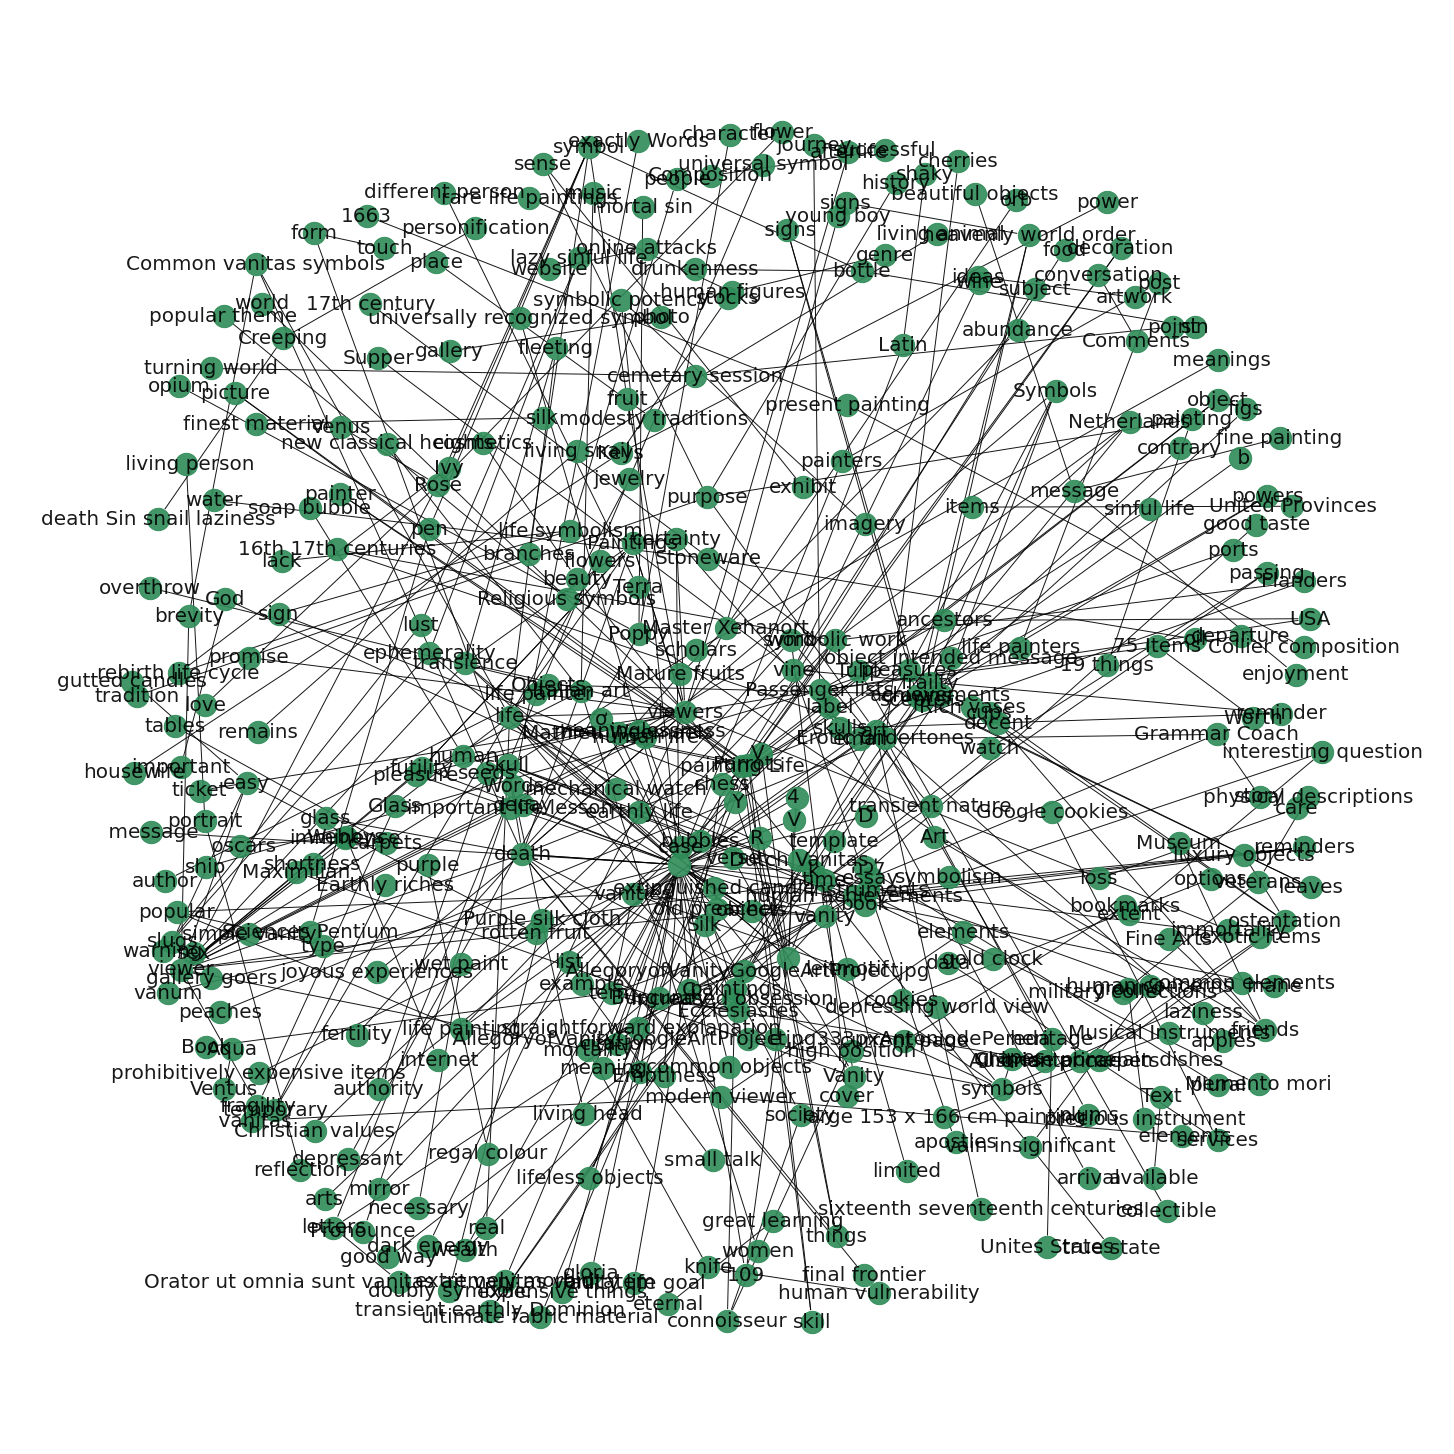

In [58]:
display_kg(DG)

In [72]:
DG.nodes['Africa']

{'bipartite': 1}

In [60]:
src_dir = 'srl_kg_admatrix_nodelist_total'
nx.write_gpickle(DG, "kg_srl/vanitas_meaning_KG_SRL.gpickle") 
save_admatrix_nodelist(DG, src_dir)

In [20]:
nx.descendants(DG, 'skull')

NetworkXError: The node skull is not in the graph.

In [22]:
DG_single = nx.DiGraph()
text = 'Everything on the table, from the fluted glass and goblet to the lobster and crab, is indeed life-like. You can almost smell the lemons. The Dutch proudly displayed such expensive status symbols in their homes, the exotic food and material possessions reminding them of the good things in life, even as the watch reminds them of their transience. The bread and wine, in a touch of Christian symbolism, echo the moralizing message of vanitas, or vanity: all earthly things must pass.'
create_kg_from_text(text, DG_single)

1
1
1
1
1
1
1
1
1
1
1


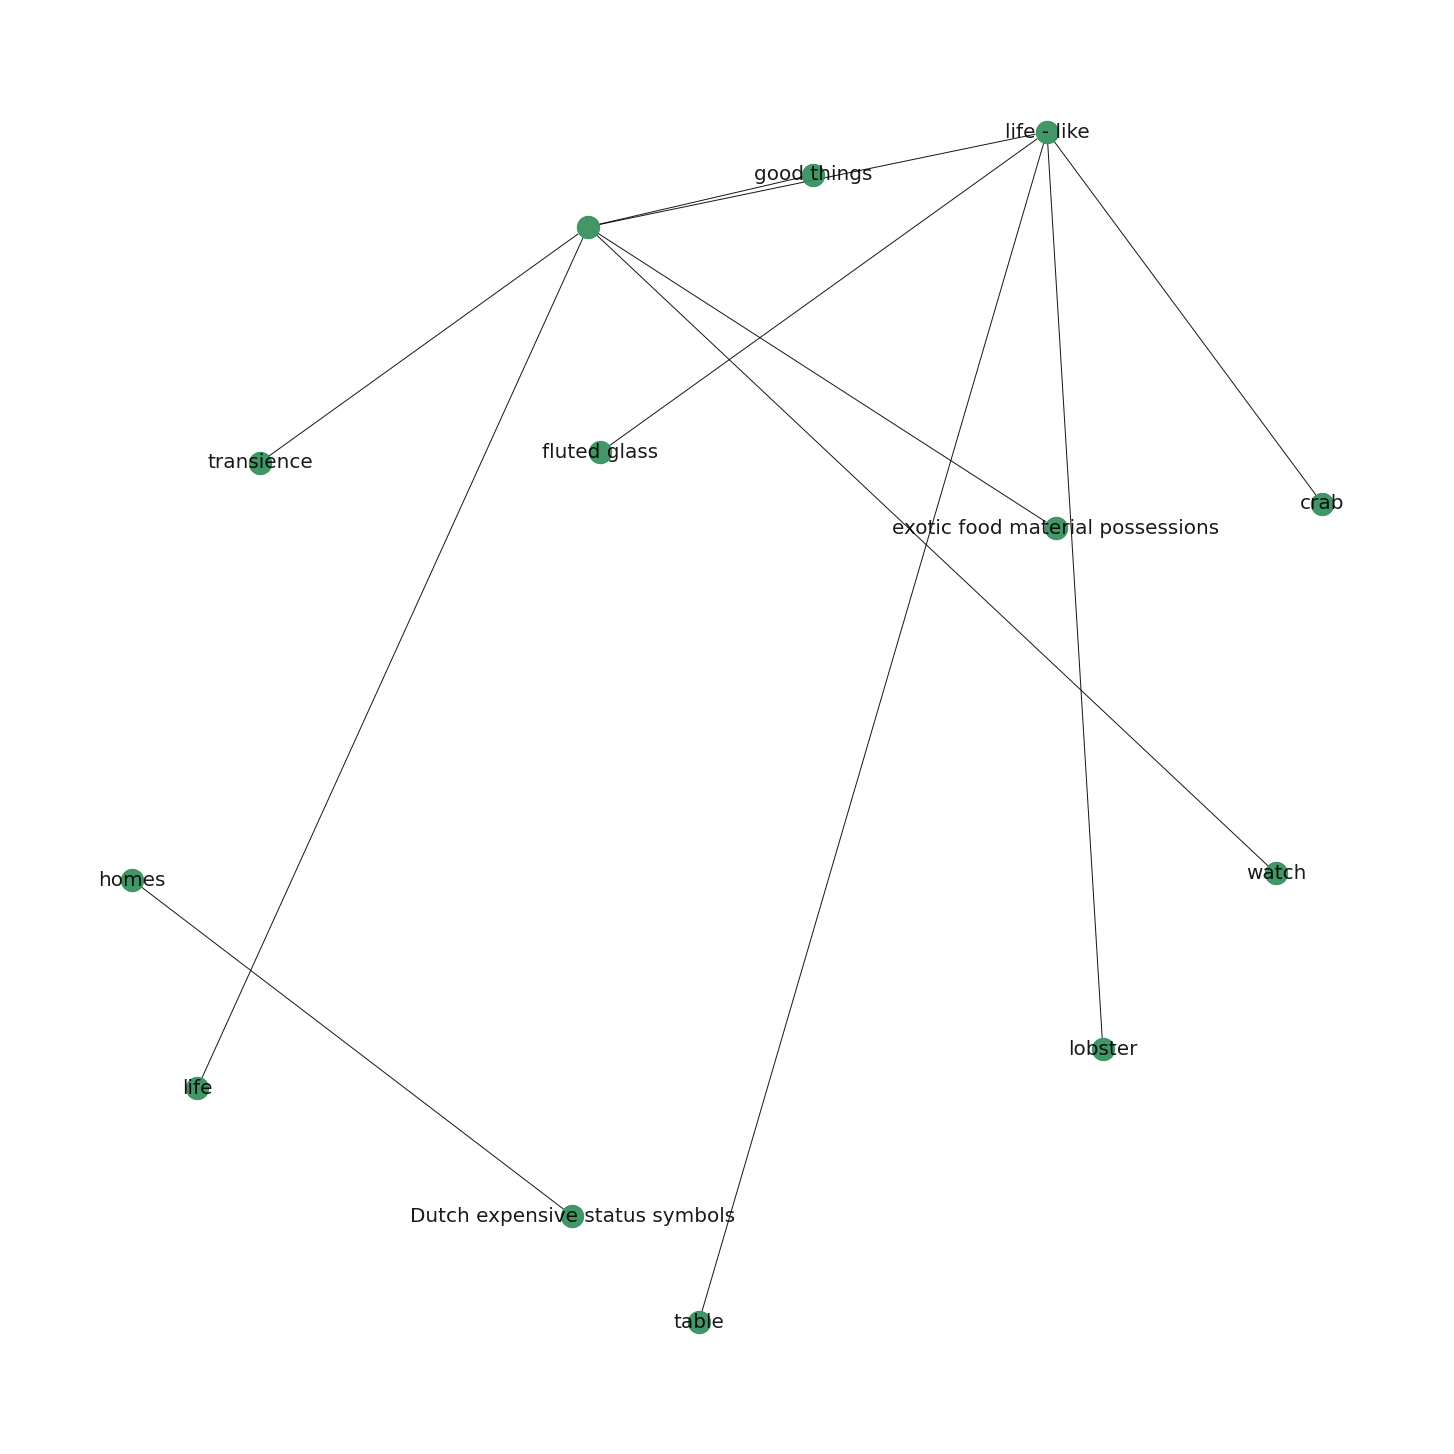

In [54]:
display_kg(DG_single)

In [153]:

src_dir = 'srl_kg_admatrix_nodelist_single'

save_admatrix_nodelist(DG_single, src_dir)


In [55]:
nx.write_gpickle(DG, "kg_srl/vanitas_meaning_KG_SRL.gpickle") 

In [53]:
nx.descendants(DG_single, 'Skull')

NetworkXError: The node Skull is not in the graph.

In [133]:
DG_single.nodes

NodeView(('', 'life - like', 'table', 'fluted glass', 'lobster', 'crab', 'Dutch expensive status symbols', 'homes', 'exotic food material possessions', 'good things', 'life', 'watch', 'transience'))

In [71]:
def remove_stop_words(text):
    sent = []
    for word in text.split(' '):
            lexeme = nlp.vocab[word]
            if lexeme.is_stop == False:
                sent.append(word)
    return ' '.join(sent)
    
        
def find_noun_chunks(words):
    doc = nlp(words)

    if not list(doc.noun_chunks):
        return [words]
    chunks = []
    for chunk in doc.noun_chunks:
        sent = remove_stop_words(chunk.text)
        chunks.append(sent)
    return chunks


words = 'The passing of time.'
remove_stop_words(words)

'passing time.'

True

In [40]:
words = 'the passing of time'
find_noun_chunks(words)

['passing', 'time']

In [59]:
doc = nlp("Abraham Mignon,  National Museum, Warsaw, Africa, west east indies, west coast")

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Abraham Mignon 0 14 PERSON
National Museum 17 32 ORG
Warsaw 34 40 GPE
Africa 42 48 GPE
west east indies 50 66 LOC
west coast 68 78 LOC


In [60]:
ent.label_

'LOC'

In [6]:
len(val_texts)

19